In [233]:
import yfinance as yf
import pandas as pd

# SPYの日次データを取得
spy = yf.Ticker("SPY")
spy_data = spy.history(period="max", interval="1d")
spy_close = spy_data[['Close']].copy()
spy_close.columns = ['SPY_Close']

print(f"SPYデータ取得完了: {len(spy_close)}日分")
print(f"期間: {spy_close.index[0].date()} から {spy_close.index[-1].date()}")

# VIXの日次データを取得
vix = yf.Ticker("^VIX")
vix_data = vix.history(period="max", interval="1d")
vix_close = vix_data[['Close']].copy()
vix_close.columns = ['VIX_Close']

print(f"VIXデータ取得完了: {len(vix_close)}日分")
print(f"期間: {vix_close.index[0].date()} から {vix_close.index[-1].date()}")
spy_close.index = spy_close.index.date
vix_close.index = vix_close.index.date
spy_close.index = pd.to_datetime(spy_close.index)
vix_close.index = pd.to_datetime(vix_close.index)


# SPYとVIXのデータを結合
data = pd.merge(spy_close, vix_close, left_index=True, right_index=True, how='inner')

print(f"\n結合後のデータ: {len(data)}日分")
print(f"期間: {data.index[0].date()} から {data.index[-1].date()}")

# 基本統計量を表示
print("\n基本統計量:")
print(data.describe())

# 最初の5行を表示
print("\n最初の5行:")
print(data.head())

# 保存
data.to_csv('SPY_VIX.csv')

SPYデータ取得完了: 8151日分
期間: 1993-01-29 から 2025-06-16
VIXデータ取得完了: 8930日分
期間: 1990-01-02 から 2025-06-16

結合後のデータ: 8151日分
期間: 1993-01-29 から 2025-06-16

基本統計量:
       SPY_Close  VIX_Close
count   8151.000   8151.000
mean     158.139     19.560
std      137.534      8.056
min       24.157      9.140
25%       70.709     13.710
50%       94.664     17.710
75%      209.403     23.010
max      611.092     82.690

最初の5行:
            SPY_Close  VIX_Close
1993-01-29     24.453     12.420
1993-02-01     24.626     12.330
1993-02-02     24.679     12.250
1993-02-03     24.939     12.120
1993-02-04     25.044     12.290


In [234]:
# 日次リターンとボラティリティを計算
data['SPY_Return'] = data['SPY_Close'].pct_change()
data['SPY_Monthly_Return'] = data['SPY_Return'].rolling(window=21).mean() * 252
data['Rolling_Vol'] = data['SPY_Return'].rolling(window=21).std() * np.sqrt(252)  # 20日ローリング、年率換算

# 日次データフレームを作成（NaN削除）
daily_data = pd.DataFrame({
    'Return': data['SPY_Return'],
    'Rolling_Return': data['SPY_Monthly_Return'],
    'Volatility': data['Rolling_Vol'],
    'VIX': data['VIX_Close'],
    'SPY_Close': data['SPY_Close']
})
daily_data = daily_data.dropna()

# GMMの入力特徴量を準備（日次リターンとボラティリティ）
features = daily_data[["Rolling_Return", 'VIX', 'Volatility']].values

# ガウス混合モデルでレジームを推定（3レジーム）
gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
gmm.fit(features)

# レジーム確率とラベルを取得
regime_probs = gmm.predict_proba(features)
regime_labels = gmm.predict(features)

# スムージング
regime_probs = pd.DataFrame(regime_probs).rolling(3).mean().values
regime_labels = np.argmax(regime_probs,axis=1)

レジーム統計（日次）:
Bear: 平均リターン=3.9%（年率）, 平均ボラティリティ=43.9%, 平均VIX=41.2, 日数=458日
Neutral: 平均リターン=11.0%（年率）, 平均ボラティリティ=18.9%, 平均VIX=22.9, 日数=3,706日
Bull: 平均リターン=13.2%（年率）, 平均ボラティリティ=10.1%, 平均VIX=14.0, 日数=3,966日


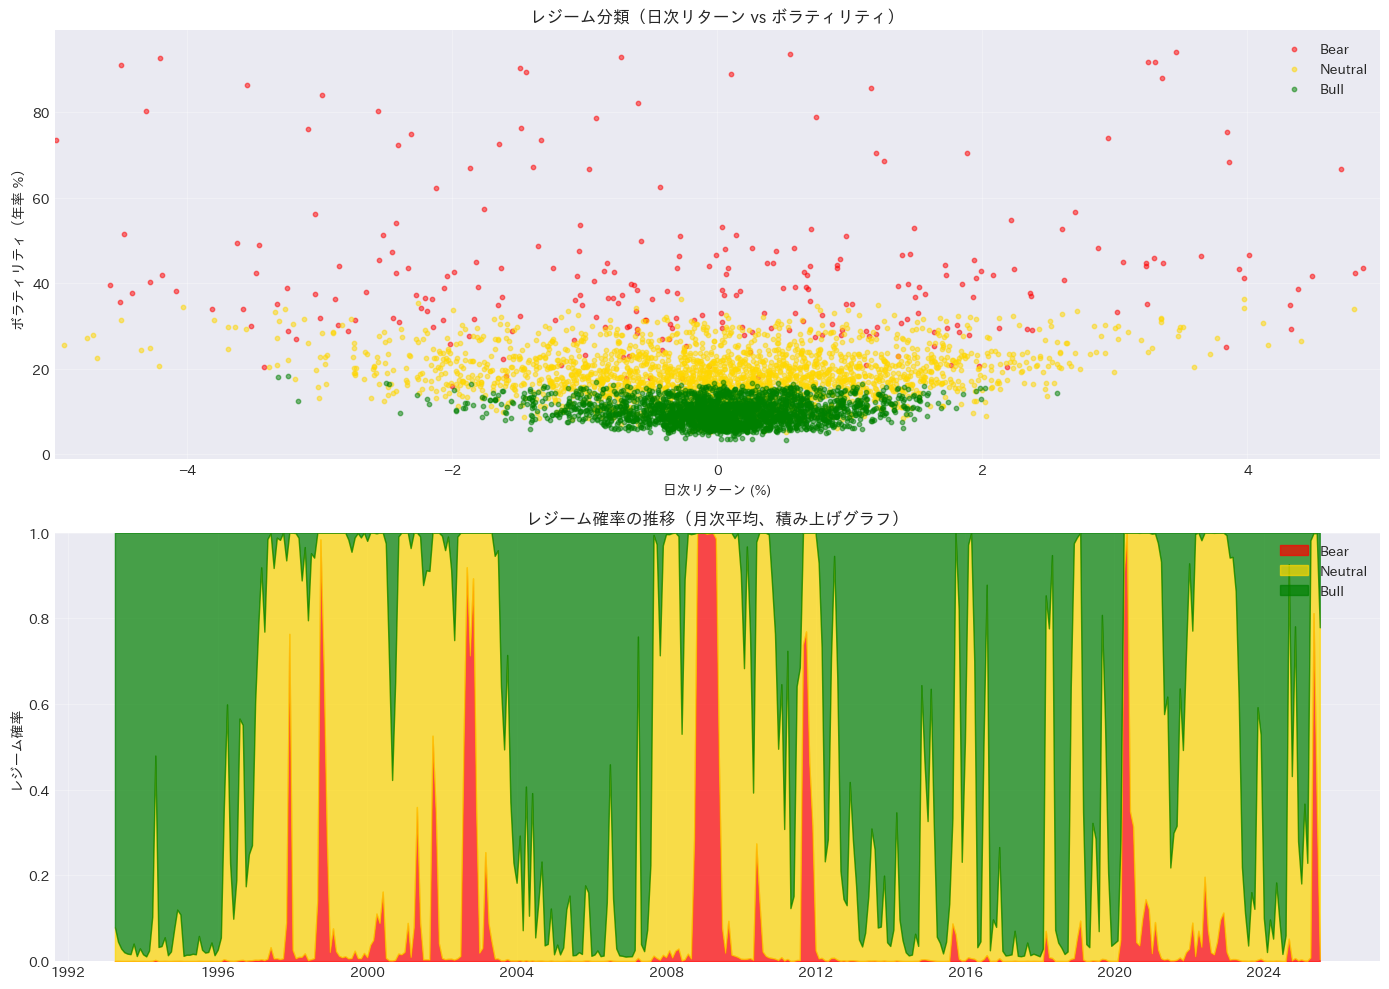

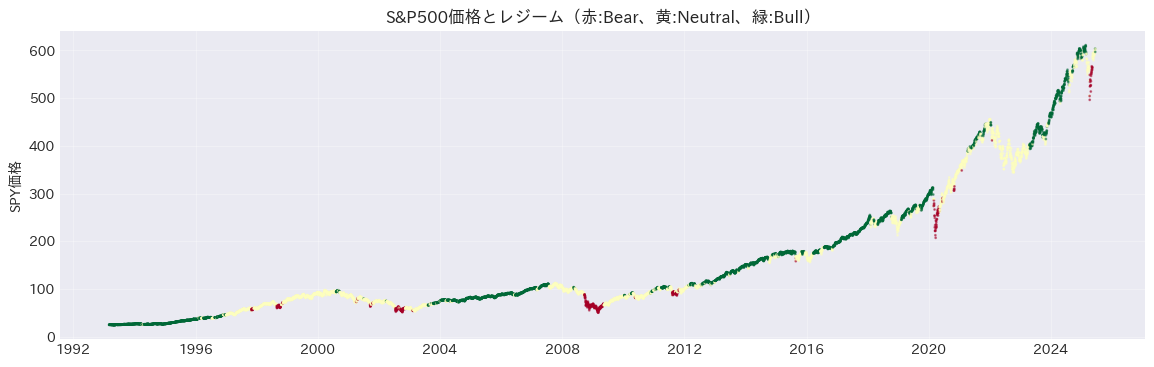

In [235]:

# 各レジームの特徴を計算してレジーム名を割り当て
regime_stats = []
for i in range(3):
    mask = regime_labels == i
    avg_return = daily_data.loc[mask, 'Return'].mean()
    avg_vol = daily_data.loc[mask, 'Volatility'].mean()
    avg_vix = daily_data.loc[mask, 'VIX'].mean()
    count = mask.sum()
    regime_stats.append({
        'regime_id': i,
        'avg_return': avg_return,
        'avg_vol': avg_vol,
        'avg_vix': avg_vix,
        'count': count
    })

# リターンでソートしてBear, Neutral, Bullを割り当て
regime_stats = sorted(regime_stats, key=lambda x: x['avg_return'])
regime_mapping = {regime_stats[0]['regime_id']: 'Bear',
                 regime_stats[1]['regime_id']: 'Neutral', 
                 regime_stats[2]['regime_id']: 'Bull'}

# レジーム名を割り当て
daily_data['Regime'] = [regime_mapping[label] for label in regime_labels]
daily_data['Bear_Prob'] = regime_probs[:, regime_stats[0]['regime_id']]
daily_data['Neutral_Prob'] = regime_probs[:, regime_stats[1]['regime_id']]
daily_data['Bull_Prob'] = regime_probs[:, regime_stats[2]['regime_id']]
daily_data = daily_data.dropna()

# レジーム統計を表示
print("レジーム統計（日次）:")
for i, stats in enumerate(regime_stats):
    regime_name = ['Bear', 'Neutral', 'Bull'][i]
    print(f"{regime_name}: 平均リターン={stats['avg_return']*252:.1%}（年率）, "
          f"平均ボラティリティ={stats['avg_vol']:.1%}, "
          f"平均VIX={stats['avg_vix']:.1f}, "
          f"日数={stats['count']:,}日")

# レジーム可視化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 散布図でレジーム分類を表示（サンプリングして見やすくする）
sample_size = min(5000, len(daily_data))
sample_idx = np.random.choice(len(daily_data), sample_size, replace=False)
sample_data = daily_data.iloc[sample_idx]

colors = {'Bear': 'red', 'Neutral': 'gold', 'Bull': 'green'}
for regime in ['Bear', 'Neutral', 'Bull']:
    mask = sample_data['Regime'] == regime
    ax1.scatter(sample_data.loc[mask, 'Return'] * 100, 
               sample_data.loc[mask, 'Volatility'] * 100,
               c=colors[regime], label=regime, alpha=0.5, s=10)
ax1.set_xlabel('日次リターン (%)')
ax1.set_ylabel('ボラティリティ（年率 %）')
ax1.set_title('レジーム分類（日次リターン vs ボラティリティ）')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-5, 5)  # 外れ値を除外して見やすくする

# レジーム確率の積み上げグラフ（月次で集約して見やすくする）
monthly_probs = daily_data[['Bear_Prob', 'Neutral_Prob', 'Bull_Prob']].resample('M').mean()

ax2.fill_between(monthly_probs.index, 0, monthly_probs['Bear_Prob'], 
                 color='red', alpha=0.7, label='Bear')
ax2.fill_between(monthly_probs.index, monthly_probs['Bear_Prob'], 
                 monthly_probs['Bear_Prob'] + monthly_probs['Neutral_Prob'], 
                 color='gold', alpha=0.7, label='Neutral')
ax2.fill_between(monthly_probs.index, 
                 monthly_probs['Bear_Prob'] + monthly_probs['Neutral_Prob'], 
                 1.0, color='green', alpha=0.7, label='Bull')
ax2.set_ylabel('レジーム確率')
ax2.set_ylim(0, 1)
ax2.set_title('レジーム確率の推移（月次平均、積み上げグラフ）')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 各レジームの期間を可視化
fig, ax = plt.subplots(figsize=(14, 4))
regime_colors = daily_data['Regime'].map({'Bear': 0, 'Neutral': 1, 'Bull': 2})
ax.scatter(daily_data.index, daily_data['SPY_Close'], 
          c=regime_colors, cmap='RdYlGn', s=1, alpha=0.5)
ax.set_ylabel('SPY価格')
ax.set_title('S&P500価格とレジーム（赤:Bear、黄:Neutral、緑:Bull）')
ax.grid(True, alpha=0.3)
plt.show()

In [236]:
# import numpy as np
# from sklearn.mixture import GaussianMixture
# import matplotlib.pyplot as plt
# import matplotlib_fontja

# # 月次リターンを計算
# data['SPY_Return'] = data['SPY_Close'].pct_change()
# data['SPY_Return_Monthly'] = data['SPY_Close'].resample('M').last().pct_change()

# # 月次ボラティリティを計算（日次リターンの標準偏差を月次で集計）
# monthly_vol = data['SPY_Return'].resample('M').std() * np.sqrt(21)  # 21営業日で年率換算

# # 月次データフレームを作成
# monthly_data = pd.DataFrame({
#     'Return': data['SPY_Return_Monthly'],
#     'Volatility': monthly_vol,
#     'VIX_Monthly': data['VIX_Close'].resample('M').last()
# })
# monthly_data = monthly_data.dropna()

# # GMMの入力特徴量を準備（リターンとボラティリティ）
# features = monthly_data[['Return', 'Volatility']].values

# # ガウス混合モデルでレジームを推定（3レジーム）
# gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
# gmm.fit(features)

# # レジーム確率とラベルを取得
# regime_probs = gmm.predict_proba(features)
# regime_labels = gmm.predict(features)

# # 各レジームの特徴を計算してレジーム名を割り当て
# regime_stats = []
# for i in range(3):
#     mask = regime_labels == i
#     avg_return = monthly_data.loc[mask, 'Return'].mean()
#     avg_vol = monthly_data.loc[mask, 'Volatility'].mean()
#     count = mask.sum()
#     regime_stats.append({
#         'regime_id': i,
#         'avg_return': avg_return,
#         'avg_vol': avg_vol,
#         'count': count
#     })

# # リターンでソートしてBear, Neutral, Bullを割り当て
# regime_stats = sorted(regime_stats, key=lambda x: x['avg_return'])
# regime_mapping = {regime_stats[0]['regime_id']: 'Bear',
#                  regime_stats[1]['regime_id']: 'Neutral', 
#                  regime_stats[2]['regime_id']: 'Bull'}

# # レジーム名を割り当て
# monthly_data['Regime'] = [regime_mapping[label] for label in regime_labels]
# monthly_data['Bear_Prob'] = regime_probs[:, regime_stats[0]['regime_id']]
# monthly_data['Neutral_Prob'] = regime_probs[:, regime_stats[1]['regime_id']]
# monthly_data['Bull_Prob'] = regime_probs[:, regime_stats[2]['regime_id']]


# # レジーム統計を表示
# print("レジーム統計:")
# for i, stats in enumerate(regime_stats):
#     regime_name = ['Bear', 'Neutral', 'Bull'][i]
#     print(f"{regime_name}: 平均リターン={stats['avg_return']:.2%}, "
#           f"平均ボラティリティ={stats['avg_vol']:.2%}, "
#           f"期間数={stats['count']}")

# # レジーム可視化
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# # 散布図でレジーム分類を表示
# colors = {'Bear': 'red', 'Neutral': 'yellow', 'Bull': 'green'}
# for regime in ['Bear', 'Neutral', 'Bull']:
#     mask = monthly_data['Regime'] == regime
#     ax1.scatter(monthly_data.loc[mask, 'Return'] * 100, 
#                monthly_data.loc[mask, 'Volatility'] * 100,
#                c=colors[regime], label=regime, alpha=0.6, s=50)
# ax1.set_xlabel('月次リターン (%)')
# ax1.set_ylabel('月次ボラティリティ (%)')
# ax1.set_title('レジーム分類（リターン vs ボラティリティ）')
# ax1.legend()
# ax1.grid(True, alpha=0.3)

# # レジーム確率の積み上げグラフ
# ax2.fill_between(monthly_data.index, 0, monthly_data['Bear_Prob'], 
#                  color='red', alpha=0.7, label='Bear')
# ax2.fill_between(monthly_data.index, monthly_data['Bear_Prob'], 
#                  monthly_data['Bear_Prob'] + monthly_data['Neutral_Prob'], 
#                  color='gold', alpha=0.7, label='Neutral')
# ax2.fill_between(monthly_data.index, 
#                  monthly_data['Bear_Prob'] + monthly_data['Neutral_Prob'], 
#                  1.0, color='green', alpha=0.7, label='Bull')

# ax2.set_ylabel('レジーム確率')
# ax2.set_ylim(0, 1)
# ax2.set_title('レジーム確率の推移（積み上げグラフ）')
# ax2.legend(loc='upper right')
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [237]:
display(daily_data.groupby('Regime').mean())
display(daily_data.groupby('Regime').count())

,Return,Rolling_Return,Volatility,VIX,SPY_Close,Bear_Prob,Neutral_Prob,Bull_Prob
Regime,,,,,,,,
Bear,0.000,-0.322,0.439,41.205,117.723,0.911,0.089,0.000
Bull,0.001,0.202,0.101,14.014,161.095,0.001,0.093,0.906
Neutral,0.000,0.078,0.189,22.854,160.801,0.035,0.892,0.073


,Return,Rolling_Return,Volatility,VIX,SPY_Close,Bear_Prob,Neutral_Prob,Bull_Prob
Regime,,,,,,,,
Bear,458,458,458,458,458,458,458,458
Bull,3964,3964,3964,3964,3964,3964,3964,3964
Neutral,3706,3706,3706,3706,3706,3706,3706,3706


In [262]:
daily_returns

1993-03-04   -0.006
1993-03-05   -0.003
1993-03-08    0.022
1993-03-09   -0.003
1993-03-10    0.002
              ...  
2025-06-10    0.006
2025-06-11   -0.003
2025-06-12    0.004
2025-06-13   -0.011
2025-06-16    0.010
Name: Return, Length: 8128, dtype: float64

In [263]:
import scipy
# 1. 日次リターンを抽出
daily_returns = daily_data[daily_data['Regime']=='Bear']['Return'].dropna()

# 2. t分布をフィッティング
df_t, loc_t, scale_t = scipy.stats.t.fit(daily_returns)

print(f"t分布フィット結果: df={df_t:.2f}, loc={loc_t:.5f}, scale={scale_t:.5f}")

t分布フィット結果: df=4.22, loc=-0.00010, scale=0.02132


In [264]:
# パラメータに基づき、t分布に従う日次リターンをサンプリングし、
# 21日分足し合わせて月次リターンをシミュレート
N = 100000  # モンテカルロ試行数
simulated_monthly_returns = []

for _ in range(N):
    r = scipy.stats.t.rvs(df_t, loc=loc_t, scale=scale_t, size=21)
    monthly_return = np.sum(r)  # 合計で月次リターン
    simulated_monthly_returns.append(monthly_return)

simulated_monthly_returns = np.array(simulated_monthly_returns)


In [265]:
def simulate_pput_return(monthly_returns, put_cost, hedge_ratio, moneyness=0.95):
    """
    ヘッジ戦略のリターンをシミュレート（PPUT）
    """
    strike_price = moneyness
    end_prices = 1 + monthly_returns
    payoff = np.clip(strike_price - end_prices, 0, None) * hedge_ratio
    hedge_cost = put_cost * hedge_ratio
    strategy_returns = monthly_returns - hedge_cost + payoff
    return strategy_returns


In [266]:
def calculate_cvar(returns, alpha=0.05):
    return np.sort(returns)[:int(alpha * len(returns))].mean()

def calculate_sharpe(returns, rf=0.0):
    excess = returns - rf
    return excess.mean() / excess.std()

# 仮のプットコスト（例えば価格比で1%）
put_cost = 0.01
moneyness = 0.95

results = []
for h in np.linspace(0.0, 1.0, 21):
    strat_r = simulate_pput_return(simulated_monthly_returns, put_cost, hedge_ratio=h, moneyness=moneyness)
    cvar = calculate_cvar(strat_r)
    sharpe = calculate_sharpe(strat_r)
    results.append({'hedge_ratio': h, 'CVaR': cvar, 'Sharpe': sharpe})


In [267]:
import pandas as pd

df = pd.DataFrame(results)

best_cvar = df.loc[df['CVaR'].idxmax()]
best_sharpe = df.loc[df['Sharpe'].idxmax()]

print("\n最適ヘッジ戦略（t分布ベースの月次リターンシミュレーション）")
print(f"▶ CVaR最大: ヘッジ比率 = {best_cvar['hedge_ratio']:.2f}, CVaR = {best_cvar['CVaR']:.2%}")
print(f"▶ Sharpe最大: ヘッジ比率 = {best_sharpe['hedge_ratio']:.2f}, SR = {best_sharpe['Sharpe']:.2f}")



最適ヘッジ戦略（t分布ベースの月次リターンシミュレーション）
▶ CVaR最大: ヘッジ比率 = 1.00, CVaR = -6.00%
▶ Sharpe最大: ヘッジ比率 = 1.00, SR = 0.21


In [238]:
from scipy.stats import norm

# プットオプション価格計算（Black-Scholesモデル）
def calculate_put_price(S, K, r, sigma, T):
    """
    S: 現在の株価
    K: 行使価格
    r: リスクフリーレート
    sigma: ボラティリティ（年率）
    T: 満期までの時間（年）
    """
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    put_price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    return put_price

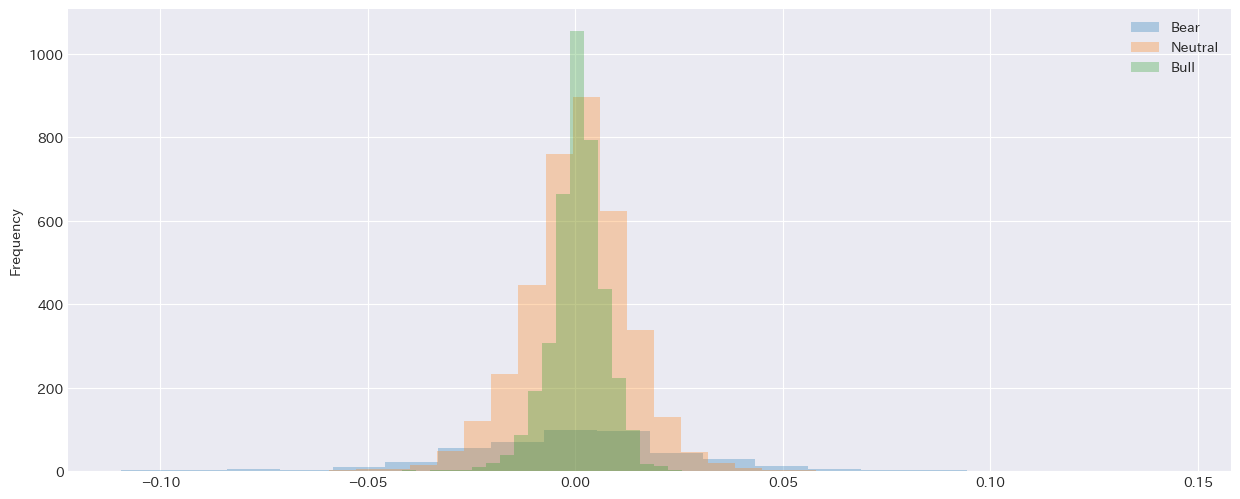

In [239]:
plt.figure(figsize=(15,6))
daily_data[daily_data['Regime']=='Bear'].loc[:,'Return'].plot.hist(bins=20,alpha=0.3,label='Bear')
daily_data[daily_data['Regime']=='Neutral'].loc[:,'Return'].plot.hist(bins=20,alpha=0.3,label='Neutral')
daily_data[daily_data['Regime']=='Bull'].loc[:,'Return'].plot.hist(bins=20,alpha=0.3,label='Bull')
plt.legend()
plt.show()

In [243]:
# 面倒なので月末を取っている
monthly_data = daily_data.resample('M').last()
monthly_data["SPY_MonthlyReturn"] = monthly_data["SPY_Close"].pct_change()
monthly_data.dropna(inplace=True)

In [244]:
monthly_data

,Return,Rolling_Return,Volatility,VIX,SPY_Close,Regime,Bear_Prob,Neutral_Prob,Bull_Prob,SPY_MonthlyReturn
1993-04-30,0.001,-0.304,0.117,12.420,24.620,Bull,0.001,0.074,0.926,-0.026
1993-05-31,-0.005,0.342,0.109,13.470,25.284,Bull,0.000,0.026,0.974,0.027
1993-06-30,0.000,-0.068,0.091,11.260,25.376,Bull,0.000,0.016,0.984,0.004
1993-07-31,-0.006,-0.055,0.080,11.730,25.252,Bull,0.000,0.014,0.986,-0.005
1993-08-31,0.003,0.420,0.052,11.850,26.220,Bull,0.000,0.018,0.982,0.038
...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.016,-0.145,0.127,19.630,592.398,Neutral,0.004,0.705,0.292,-0.013
2025-03-31,0.007,-0.667,0.207,22.280,559.390,Neutral,0.005,0.992,0.003,-0.056
2025-04-30,0.000,0.025,0.527,24.700,554.540,Bear,1.000,0.000,0.000,-0.009
2025-05-31,-0.001,0.746,0.170,18.570,589.390,Neutral,0.006,0.979,0.015,0.063



プットオプション価格（SPY価格に対する比率）:
マネネス0.9: 平均0.001 (0.1%)
マネネス0.95: 平均0.006 (0.6%)
マネネス1.0: 平均0.022 (2.2%)


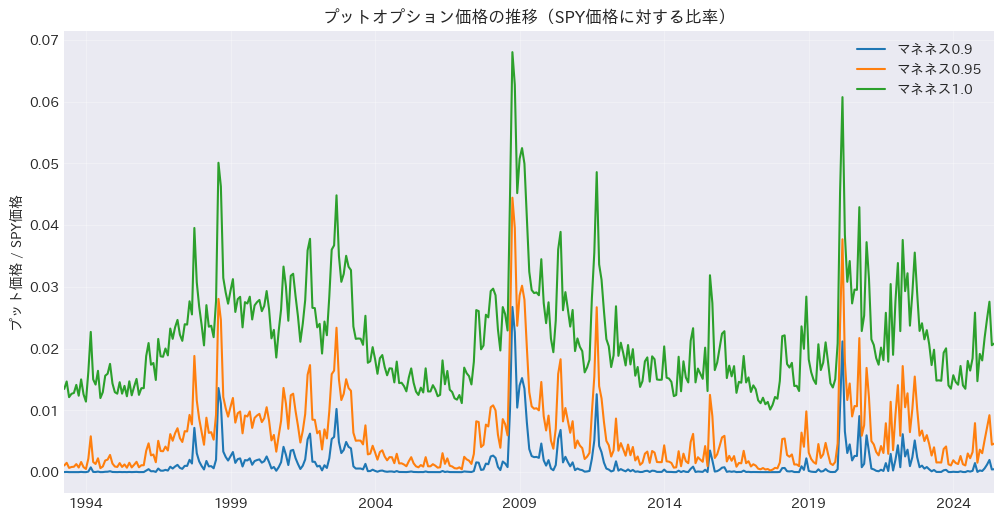

In [245]:


# パラメータ設定
r = 0.02  # リスクフリーレート（年率2%）
T = 1/12  # 1ヶ月満期
moneyness_levels = [0.90, 0.95, 1.00]  # マネネスレベル

# 各月・各マネネスでのプットオプション価格を計算
for moneyness in moneyness_levels:
    put_prices = []
    
    for idx, row in monthly_data.iterrows():
        S = data['SPY_Close'].loc[:idx].iloc[-1]  # 月末のSPY価格
        K = S * moneyness  # 行使価格
        sigma = row['VIX'] / 100
        
        put_price = calculate_put_price(S, K, r, sigma, T)
        put_prices.append(put_price / S)  # SPY価格に対する比率として保存
    
    monthly_data[f'Put_Price_{moneyness}'] = put_prices

# プットオプション価格の統計を表示
print("\nプットオプション価格（SPY価格に対する比率）:")
for moneyness in moneyness_levels:
    col = f'Put_Price_{moneyness}'
    mean_price = monthly_data[col].mean()
    print(f"マネネス{moneyness}: 平均{mean_price:.3f} ({mean_price*100:.1f}%)")

# プットオプション価格の可視化
fig, ax = plt.subplots(figsize=(12, 6))
for moneyness in moneyness_levels:
    monthly_data[f'Put_Price_{moneyness}'].plot(ax=ax, label=f'マネネス{moneyness}')
ax.set_ylabel('プット価格 / SPY価格')
ax.set_title('プットオプション価格の推移（SPY価格に対する比率）')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [249]:
daily_data

,Return,Rolling_Return,Volatility,VIX,SPY_Close,Regime,Bear_Prob,Neutral_Prob,Bull_Prob
1993-03-04,-0.006,0.151,0.131,13.440,24.974,Bull,0.000,0.054,0.946
1993-03-05,-0.003,-0.009,0.127,14.080,24.905,Bull,0.000,0.044,0.956
1993-03-08,0.022,0.209,0.148,16.220,25.461,Bull,0.000,0.078,0.922
1993-03-09,-0.003,0.176,0.149,14.170,25.374,Bull,0.000,0.109,0.891
1993-03-10,0.002,0.201,0.149,13.910,25.426,Bull,0.001,0.147,0.852
...,...,...,...,...,...,...,...,...,...
2025-06-10,0.006,0.810,0.160,16.950,603.080,Neutral,0.005,0.921,0.074
2025-06-11,-0.003,0.379,0.119,17.260,601.360,Neutral,0.004,0.665,0.331
2025-06-12,0.004,0.348,0.118,18.020,603.750,Bull,0.002,0.456,0.542
2025-06-13,-0.011,0.198,0.126,20.820,597.000,Bull,0.002,0.436,0.562


In [232]:
monthly_data[monthly_data['Regime']=='Bear']

,Return,Rolling_Return,Volatility,VIX,SPY_Close,Regime,Bear_Prob,Neutral_Prob,Bull_Prob,SPY_MonthlyReturn,Put_Price_0.9,Put_Price_0.95,Put_Price_1.0
2011-08-31,0.004,-0.208,0.474,31.620,95.192,Bear,1.000,0.000,0.000,-0.055,0.005,0.015,0.036
2011-09-30,-0.025,-0.822,0.290,42.960,88.583,Bear,0.926,0.074,0.000,-0.069,0.013,0.027,0.049
2011-10-31,-0.024,1.286,0.289,29.960,98.252,Bear,0.512,0.488,0.000,0.109,0.004,0.014,0.034
2020-02-29,-0.004,-1.139,0.243,40.110,273.846,Bear,0.638,0.362,0.000,-0.079,0.011,0.024,0.045
2020-03-31,-0.015,-1.710,0.902,53.540,239.651,Bear,1.000,0.000,0.000,-0.125,0.021,0.038,0.061
2020-04-30,-0.009,1.516,0.404,34.150,270.082,Bear,1.000,0.000,0.000,0.127,0.007,0.018,0.038
2020-10-31,-0.010,-0.359,0.207,38.020,306.167,Bear,0.925,0.075,0.000,-0.025,0.009,0.022,0.043
2021-01-31,-0.020,-0.033,0.160,33.090,348.460,Bear,0.533,0.467,0.000,-0.010,0.006,0.017,0.037
2025-04-30,0.000,0.025,0.527,24.700,554.540,Bear,1.000,0.000,0.000,-0.009,0.002,0.009,0.028


In [230]:
import itertools
from scipy.stats import norm

def calculate_strategy_return(spy_returns, put_costs, hedge_ratio, moneyness=0.95):
    """
    SPYとプットの合成リターンを計算（マネネスに応じた正確なプットペイオフ）

    Parameters:
    - spy_returns: 月次SPYリターン（例: +0.02 → +2%）
    - put_costs: プット価格（SPY価格に対する比率、例: 0.01）
    - hedge_ratio: プットの購入比率（例: 1.0 なら1単位）
    - moneyness: プットのマネネス（例: 0.95）

    Returns:
    - total_return: 合成リターン（SPY + プット）
    """
    # プレミアム支払い（常にマイナス）
    hedge_cost = put_costs * hedge_ratio

    # プットの利益（満期時点でのITM分、マネネスがストライク）
    strike_price = moneyness  # SPY価格を1としたときの行使価格
    end_price = 1 + spy_returns  # 月末のSPY価格（基準=1）
    payoff = np.clip(strike_price - end_price, 0, None) * hedge_ratio

    total_return = spy_returns - hedge_cost + payoff
    return total_return


def calculate_cvar(returns, alpha=0.05):
    """
    CVaR（条件付きVaR）を計算
    """
    sorted_returns = np.sort(returns)
    var_index = int(alpha * len(sorted_returns))
    cvar = sorted_returns[:var_index].mean()
    return cvar

def calculate_sharpe(returns, rf=0.0):
    """
    シャープレシオを計算
    """
    excess_return = returns - rf
    return excess_return.mean() / excess_return.std()


# === レジーム別に分割して分析 ===
results = []

hedge_ratios = np.linspace(0.0, 1.0, 21)  # 0%〜100%ヘッジ
regimes = ['Bear', 'Neutral', 'Bull']

for regime in regimes:
    regime_df = monthly_data[monthly_data['Regime'] == regime].copy()
    print(len(regime_df))
    if len(regime_df) < 12:
        continue  # データが少なすぎる場合はスキップ

    for moneyness in moneyness_levels:
        cost_col = f'Put_Price_{moneyness}'
        for h in hedge_ratios:
            ret = calculate_strategy_return(
                spy_returns=regime_df["SPY_MonthlyReturn"],
                put_costs=regime_df[cost_col],
                hedge_ratio=h,
                moneyness=moneyness
            )

            sharpe = calculate_sharpe(ret)
            cvar = calculate_cvar(ret)

            results.append({
                'Regime': regime,
                'Moneyness': moneyness,
                'Hedge_Ratio': h,
                'Sharpe': sharpe,
                'CVaR': cvar
            })

# 結果をDataFrameに
results_df = pd.DataFrame(results)

# 各レジームごとに最適戦略を出力（CVaR最小、シャープ最大）
print("\n--- 最適戦略（各レジーム別） ---")
for regime in regimes:
    sub_df = results_df[results_df['Regime'] == regime]
    print(len(sub_df))
    best_sharpe = sub_df.loc[sub_df['Sharpe'].idxmax()]
    best_cvar = sub_df.loc[sub_df['CVaR'].idxmax()]  # CVaRは損失なので大きいほうが望ましい

    print(f"\n【{regime}レジーム】")
    print(f"▶ シャープ比 最大: マネネス={best_sharpe['Moneyness']}, 単位={best_sharpe['Hedge_Ratio']:.2f}, SR={best_sharpe['Sharpe']:.2f}")
    print(f"▶ CVaR 最大:     マネネス={best_cvar['Moneyness']}, 単位={best_cvar['Hedge_Ratio']:.2f}, CVaR={best_cvar['CVaR']:.2%}")


9
78
99

--- 最適戦略（各レジーム別） ---
0


ValueError: attempt to get argmax of an empty sequence

In [213]:
monthly_data 

,Return,Rolling_Return,Volatility,VIX,SPY_Close,Regime,Bear_Prob,Neutral_Prob,Bull_Prob,SPY_MonthlyReturn,Put_Price_0.9,Put_Price_0.95,Put_Price_1.0
1993-04-30,0.001,-0.304,0.117,12.420,24.620,Bull,0.001,0.074,0.926,-0.026,0.000,0.001,0.013
1993-05-31,-0.005,0.342,0.109,13.470,25.284,Bull,0.000,0.026,0.974,0.027,0.000,0.002,0.015
1993-06-30,0.000,-0.068,0.091,11.260,25.376,Bull,0.000,0.016,0.984,0.004,0.000,0.001,0.012
1993-07-31,-0.006,-0.055,0.080,11.730,25.252,Bull,0.000,0.014,0.986,-0.005,0.000,0.001,0.013
1993-08-31,0.003,0.420,0.052,11.850,26.220,Bull,0.000,0.018,0.982,0.038,0.000,0.001,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.016,-0.145,0.127,19.630,592.398,Neutral,0.004,0.707,0.289,-0.013,0.001,0.005,0.022
2025-03-31,0.007,-0.667,0.207,22.280,559.390,Neutral,0.005,0.992,0.003,-0.056,0.001,0.007,0.025
2025-04-30,0.000,0.025,0.527,24.700,554.540,Bear,1.000,0.000,0.000,-0.009,0.002,0.009,0.028
2025-05-31,-0.001,0.746,0.170,18.570,589.390,Neutral,0.006,0.979,0.015,0.063,0.000,0.004,0.021


In [214]:
from collections import defaultdict

# 2010年以降に絞る
monthly_data = monthly_data[monthly_data.index >= '2010-01-01']
regime_monthly = daily_data['Regime'].resample('M').last()
regime_monthly = regime_monthly[regime_monthly.index >= '2010-01-01']

# 履歴全体でレジーム別にマネネス×単位ごとのCVaR・Sharpeを事前計算
strategy_results = defaultdict(list)

for regime in regimes:
    regime_df = monthly_data[regime_monthly == regime]
    if len(regime_df) < 12:
        continue

    for moneyness in moneyness_levels:
        cost_col = f'Put_Price_{moneyness}'
        for h in hedge_ratios:
            ret = calculate_strategy_return(
                spy_returns=regime_df["SPY_MonthlyReturn"],
                put_costs=regime_df[cost_col],
                hedge_ratio=h
            )
            sharpe = calculate_sharpe(ret)
            cvar = calculate_cvar(ret)
            strategy_results[regime].append({
                'Moneyness': moneyness,
                'Hedge_Ratio': h,
                'Sharpe': sharpe,
                'CVaR': cvar
            })

# シャープレシオ or CVaR最大の戦略を選択
best_strategy_by_regime = {}
for regime in regimes:
    candidates = strategy_results[regime]
    if not candidates:
        continue
    best = max(candidates, key=lambda x: x['Sharpe'])  # ←ここをCVaRに変更してCVaR最大化にも対応可能
    best_strategy_by_regime[regime] = best


# === バックテスト ===
portfolio_returns = []

for idx, row in monthly_data.iterrows():
    if idx not in regime_monthly.index:
        continue

    regime = regime_monthly.loc[idx]
    if regime not in best_strategy_by_regime:
        continue

    strategy = best_strategy_by_regime[regime]
    moneyness = strategy['Moneyness']
    h = strategy['Hedge_Ratio']

    ret = calculate_strategy_return(
        spy_returns=pd.Series(row['SPY_MonthlyReturn']),
        put_costs=pd.Series(row[f'Put_Price_{moneyness}']),
        hedge_ratio=h
    ).values[0]

    portfolio_returns.append({
        'Date': idx,
        'Return': ret,
        'Regime': regime,
        'Moneyness': moneyness,
        'Hedge_Ratio': h
    })

bt_df = pd.DataFrame(portfolio_returns).set_index('Date')

# 結果表示
print("\n=== バックテスト結果（2010年〜） ===")
print(f"平均月次リターン: {bt_df['Return'].mean():.2%}")
print(f"標準偏差: {bt_df['Return'].std():.2%}")
print(f"シャープレシオ: {calculate_sharpe(bt_df['Return']):.2f}")
print(f"CVaR(5%): {calculate_cvar(bt_df['Return']):.2%}")



=== バックテスト結果（2010年〜） ===
平均月次リターン: -0.02%
標準偏差: 0.94%
シャープレシオ: -0.02
CVaR(5%): -2.04%



=== バックテスト結果（2010年〜） ===
            Avg_Return  Volatility  Sharpe  CVaR_5%
Sharpe_Max      -0.02%       0.94%  -2.05%   -2.04%
CVaR_Max        -0.02%       0.94%  -2.05%   -2.04%
Weighted        -0.02%       0.91%  -1.81%   -1.95%
SPY_Only        -0.02%       0.94%  -2.05%   -2.04%
PPUT_0.95       -0.46%       1.06% -42.98%   -3.09%


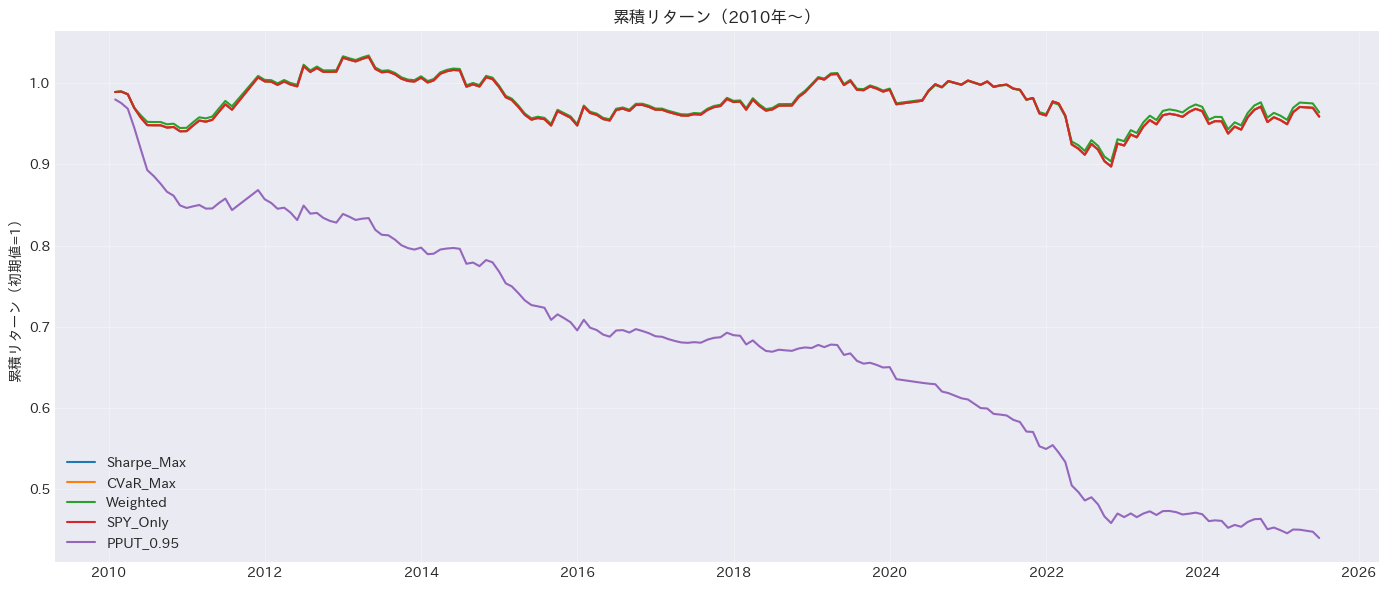

In [215]:
# --- Step 1: CVaR最大戦略を保存 ---
best_cvar_strategy_by_regime = {}
for regime in regimes:
    candidates = strategy_results[regime]
    if not candidates:
        continue
    best = max(candidates, key=lambda x: x['CVaR'])  # CVaR最大
    best_cvar_strategy_by_regime[regime] = best


# --- Step 2: レジーム確率（毎月の最終日）を取得 ---
monthly_probs = daily_data[['Bear_Prob', 'Neutral_Prob', 'Bull_Prob']].resample('M').last()
monthly_probs = monthly_probs[monthly_probs.index >= '2010-01-01']

# 戦略名: 戦略別のリターンを保存
strategy_returns = {
    'Sharpe_Max': [],
    'CVaR_Max': [],
    'Weighted': [],
    'SPY_Only': [],
    'PPUT_0.95': []  # ←ここを追加
}

# バックテスト期間でループ
for idx, row in monthly_data.iterrows():
    if idx not in regime_monthly or idx not in monthly_probs.index:
        continue

    spy_r = row['SPY_MonthlyReturn']
    weighted_r = 0.0

    # --- (A) Sharpe最大 ---
    regime = regime_monthly.loc[idx]
    strategy_A = best_strategy_by_regime.get(regime)
    if strategy_A:
        m, h = strategy_A['Moneyness'], strategy_A['Hedge_Ratio']
        ret_A = calculate_strategy_return(
            spy_returns=pd.Series(spy_r),
            put_costs=pd.Series(row[f'Put_Price_{m}']),
            hedge_ratio=h
        ).values[0]
        strategy_returns['Sharpe_Max'].append(ret_A)
    else:
        strategy_returns['Sharpe_Max'].append(np.nan)

    # --- (B) CVaR最大 ---
    strategy_B = best_cvar_strategy_by_regime.get(regime)
    if strategy_B:
        m, h = strategy_B['Moneyness'], strategy_B['Hedge_Ratio']
        ret_B = calculate_strategy_return(
            spy_returns=pd.Series(spy_r),
            put_costs=pd.Series(row[f'Put_Price_{m}']),
            hedge_ratio=h
        ).values[0]
        strategy_returns['CVaR_Max'].append(ret_B)
    else:
        strategy_returns['CVaR_Max'].append(np.nan)

    # --- (C) レジーム確率重み戦略 ---
    probs = monthly_probs.loc[idx].to_dict()
    total_weighted_ret = 0.0

    for regime_key, prob in zip(['Bear', 'Neutral', 'Bull'], 
                                [probs['Bear_Prob'], probs['Neutral_Prob'], probs['Bull_Prob']]):
        strategy = best_strategy_by_regime.get(regime_key)
        if strategy:
            m, h = strategy['Moneyness'], strategy['Hedge_Ratio']
            r = calculate_strategy_return(
                spy_returns=pd.Series(spy_r),
                put_costs=pd.Series(row[f'Put_Price_{m}']),
                hedge_ratio=h
            ).values[0]
            total_weighted_ret += prob * r
    strategy_returns['Weighted'].append(total_weighted_ret)

    # --- (D) SPYのみ（Long-only） ---
    strategy_returns['SPY_Only'].append(spy_r)
    
    # --- (E) PPUT戦略（常に0.95マネネスのプットを1枚購入） ---
    put_col = 'Put_Price_0.95'
    ret_pput = calculate_strategy_return(
        spy_returns=pd.Series(spy_r),
        put_costs=pd.Series(row[put_col]),
        hedge_ratio=1.0,  # 常に1枚購入
        moneyness=0.95
    ).values[0]
    strategy_returns['PPUT_0.95'].append(ret_pput)

# --- Step 3: データフレームにまとめる ---
bt_compare = pd.DataFrame(strategy_returns, index=monthly_data.index[:len(strategy_returns['SPY_Only'])])
bt_compare.dropna(inplace=True)

# 累積リターン
bt_cum = (1 + bt_compare).cumprod()

# 結果表示
def summarize_strategy(df):
    stats = {}
    for col in df.columns:
        r = df[col]
        stats[col] = {
            'Avg_Return': r.mean(),
            'Volatility': r.std(),
            'Sharpe': calculate_sharpe(r),
            'CVaR_5%': calculate_cvar(r)
        }
    return pd.DataFrame(stats).T

summary = summarize_strategy(bt_compare)

print("\n=== バックテスト結果（2010年〜） ===")
print(summary.to_string(float_format=lambda x: f"{x:.2%}"))

# 可視化
plt.figure(figsize=(14,6))
for col in bt_cum.columns:
    plt.plot(bt_cum.index, bt_cum[col], label=col)
plt.title("累積リターン（2010年〜）")
plt.ylabel("累積リターン（初期値=1）")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



マネネス0.95の最適化を実行中...
  最適配分: Bear=30%, Neutral=30%, Bull=30%
  シャープレシオ: 1.219
  最大ドローダウン: -19.9%

マネネス0.97の最適化を実行中...
  最適配分: Bear=30%, Neutral=30%, Bull=30%
  シャープレシオ: 1.101
  最大ドローダウン: -21.2%

マネネス0.99の最適化を実行中...
  最適配分: Bear=30%, Neutral=30%, Bull=0%
  シャープレシオ: 0.888
  最大ドローダウン: -26.1%

マネネス1.0の最適化を実行中...
  最適配分: Bear=30%, Neutral=30%, Bull=0%
  シャープレシオ: 0.756
  最大ドローダウン: -27.4%

最適化結果サマリー（S&P500 1単位に対する推奨プットオプション配分）


,moneyness,bear_weight,neutral_weight,bull_weight,avg_weight,sharpe_ratio,annual_return,annual_volatility,max_drawdown
0,0.950,0.300,0.300,0.300,0.300,1.219,0.104,0.085,-0.199
1,0.970,0.300,0.300,0.300,0.300,1.101,0.094,0.085,-0.212
2,0.990,0.300,0.300,0.000,0.251,0.888,0.085,0.096,-0.261
3,1.000,0.300,0.300,0.000,0.251,0.756,0.073,0.096,-0.274


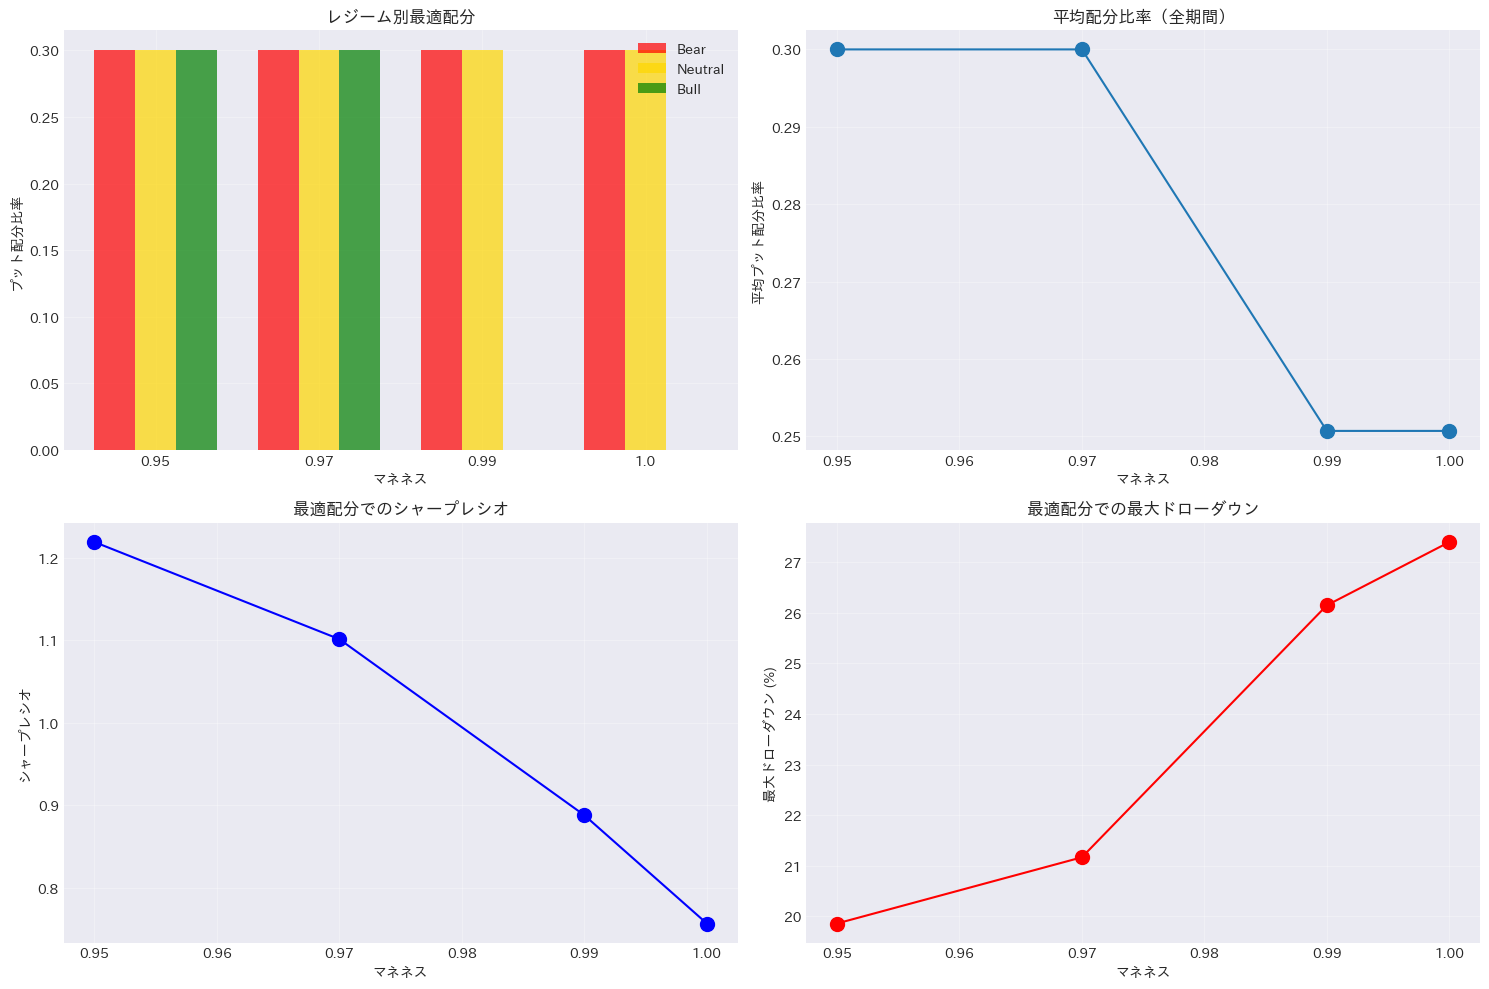


ベンチマーク（S&P500のみ）:
  シャープレシオ: 0.716
  最大ドローダウン: -38.3%


In [47]:
# レジーム確率を考慮した最適配分の計算

# グリッドサーチ用のパラメータ
weight_range = np.arange(0, 0.31, 0.05)  # 0%から30%まで5%刻み

# 各マネネスでの最適配分を計算
optimization_results = []

for moneyness in moneyness_levels:
    print(f"\nマネネス{moneyness}の最適化を実行中...")
    
    best_sharpe = -np.inf
    best_weights = None
    best_metrics = None
    
    # 各レジームでの配分を総当たりで探索
    for w_bear in weight_range:
        for w_neutral in weight_range:
            for w_bull in weight_range:
                
                # ポートフォリオのリターンを計算
                portfolio_returns = []
                
                for i in range(1, len(monthly_data)):
                    # 前月のレジーム確率で配分を決定
                    put_weight = (monthly_data.iloc[i-1]['Bear_Prob'] * w_bear + 
                                monthly_data.iloc[i-1]['Neutral_Prob'] * w_neutral + 
                                monthly_data.iloc[i-1]['Bull_Prob'] * w_bull)
                    
                    stock_weight = 1 - put_weight
                    
                    # 株式リターン
                    stock_return = monthly_data.iloc[i]['Return']
                    
                    # プットオプションのリターン（簡易計算）
                    if stock_return < 0:
                        # 下落時：プットのペイオフ
                        put_payoff = min(-stock_return * moneyness, 0.2)  # 最大20%のペイオフ
                    else:
                        put_payoff = 0
                    
                    # プットのコストを考慮
                    put_cost = monthly_data.iloc[i-1][f'Put_Price_{moneyness}']
                    put_return = put_payoff - put_cost
                    
                    # ポートフォリオリターン
                    portfolio_return = stock_weight * stock_return + put_weight * put_return
                    portfolio_returns.append(portfolio_return)
                
                # パフォーマンス指標を計算
                portfolio_returns = np.array(portfolio_returns)
                avg_return = np.mean(portfolio_returns) * 12  # 年率換算
                std_return = np.std(portfolio_returns) * np.sqrt(12)  # 年率換算
                sharpe_ratio = avg_return / std_return if std_return > 0 else 0
                
                # 最良の結果を更新
                if sharpe_ratio > best_sharpe:
                    best_sharpe = sharpe_ratio
                    best_weights = {'bear': w_bear, 'neutral': w_neutral, 'bull': w_bull}
                    
                    # ドローダウンを計算
                    cumulative_returns = np.cumprod(1 + portfolio_returns)
                    running_max = np.maximum.accumulate(cumulative_returns)
                    drawdown = (cumulative_returns - running_max) / running_max
                    max_drawdown = np.min(drawdown)
                    
                    best_metrics = {
                        'sharpe_ratio': sharpe_ratio,
                        'annual_return': avg_return,
                        'annual_volatility': std_return,
                        'max_drawdown': max_drawdown
                    }
    
    # 最適配分での平均ウェイトを計算
    avg_weight = (monthly_data['Bear_Prob'].mean() * best_weights['bear'] + 
                  monthly_data['Neutral_Prob'].mean() * best_weights['neutral'] + 
                  monthly_data['Bull_Prob'].mean() * best_weights['bull'])
    
    optimization_results.append({
        'moneyness': moneyness,
        'bear_weight': best_weights['bear'],
        'neutral_weight': best_weights['neutral'],
        'bull_weight': best_weights['bull'],
        'avg_weight': avg_weight,
        'sharpe_ratio': best_metrics['sharpe_ratio'],
        'annual_return': best_metrics['annual_return'],
        'annual_volatility': best_metrics['annual_volatility'],
        'max_drawdown': best_metrics['max_drawdown']
    })
    
    print(f"  最適配分: Bear={best_weights['bear']:.0%}, "
          f"Neutral={best_weights['neutral']:.0%}, Bull={best_weights['bull']:.0%}")
    print(f"  シャープレシオ: {best_sharpe:.3f}")
    print(f"  最大ドローダウン: {best_metrics['max_drawdown']:.1%}")

# 結果をDataFrameに変換
results_df = pd.DataFrame(optimization_results)

# 結果を表示
print("\n" + "="*70)
print("最適化結果サマリー（S&P500 1単位に対する推奨プットオプション配分）")
print("="*70)
display(results_df)

# 結果の可視化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. レジーム別配分
x = np.arange(len(moneyness_levels))
width = 0.25
ax1.bar(x - width, results_df['bear_weight'], width, label='Bear', color='red', alpha=0.7)
ax1.bar(x, results_df['neutral_weight'], width, label='Neutral', color='gold', alpha=0.7)
ax1.bar(x + width, results_df['bull_weight'], width, label='Bull', color='green', alpha=0.7)
ax1.set_xlabel('マネネス')
ax1.set_ylabel('プット配分比率')
ax1.set_title('レジーム別最適配分')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['moneyness'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 平均配分比率
ax2.plot(results_df['moneyness'], results_df['avg_weight'], 'o-', markersize=10)
ax2.set_xlabel('マネネス')
ax2.set_ylabel('平均プット配分比率')
ax2.set_title('平均配分比率（全期間）')
ax2.grid(True, alpha=0.3)

# 3. シャープレシオ
ax3.plot(results_df['moneyness'], results_df['sharpe_ratio'], 'o-', markersize=10, color='blue')
ax3.set_xlabel('マネネス')
ax3.set_ylabel('シャープレシオ')
ax3.set_title('最適配分でのシャープレシオ')
ax3.grid(True, alpha=0.3)

# 4. 最大ドローダウン
ax4.plot(results_df['moneyness'], -results_df['max_drawdown']*100, 'o-', markersize=10, color='red')
ax4.set_xlabel('マネネス')
ax4.set_ylabel('最大ドローダウン (%)')
ax4.set_title('最適配分での最大ドローダウン')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# プットなし（ベンチマーク）のパフォーマンスを計算
benchmark_returns = monthly_data['Return'].iloc[1:].values
benchmark_sharpe = (np.mean(benchmark_returns) * 12) / (np.std(benchmark_returns) * np.sqrt(12))
benchmark_cum = np.cumprod(1 + benchmark_returns)
benchmark_max = np.maximum.accumulate(benchmark_cum)
benchmark_dd = np.min((benchmark_cum - benchmark_max) / benchmark_max)

print(f"\nベンチマーク（S&P500のみ）:")
print(f"  シャープレシオ: {benchmark_sharpe:.3f}")
print(f"  最大ドローダウン: {benchmark_dd:.1%}")